## Energía Inteligente: Detección y clasificación de fallas en el sistema de transmisión de energía eléctrica utilizando redes neuronales

- Estela Monserrat Arriaga Santana

- Julián Rosas Scull

## EDA (Exploratory Data Analysis)

In [90]:
# Sirve para que no salgan los warnings de tipo FutureWarning, para algunas graficas de matplotlib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [91]:
# pandas se utiliza para manipulación de datos y lectura de los datos
import pandas as pd
import random

In [92]:
# Cargar los datos
df = pd.read_csv("./data/classData.csv")
# Mostar los primeros 5 registros
df.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


## Análisis de la base

In [93]:
# Cantidad total de observaciones
print("Cantidad total de observaciones: ", df.shape[0])


Cantidad total de observaciones:  7861


## Columnas e instancias

In [94]:
# Cantidad de columnas e instancias
num_columns = df.shape[1]
num_instances = df.shape[0]
print(f"Cantidad de columnas: {num_columns}")
print(f"Cantidad de instancias: {num_instances}")

# Tipo de dato de cada columna
data_types = df.dtypes
data_types

Cantidad de columnas: 10
Cantidad de instancias: 7861


G       int64
C       int64
B       int64
A       int64
Ia    float64
Ib    float64
Ic    float64
Va    float64
Vb    float64
Vc    float64
dtype: object

## Cantidad de columnas por tipo de dato

In [95]:
# Cantidad de columnas por tipo de dato
data_types.value_counts()

float64    6
int64      4
Name: count, dtype: int64

Nuestras columnas dependen de 2 tipos de datos, enteros y flotantes. Por lo que va a hacer crucial para la manipulación de los datos convertir los tipos enteros a tipos flotantes. Esto para comparar variables objetivos, etc.

## Cantidad de Columnas e Instancias y Tipo de Dato de Cada Columna

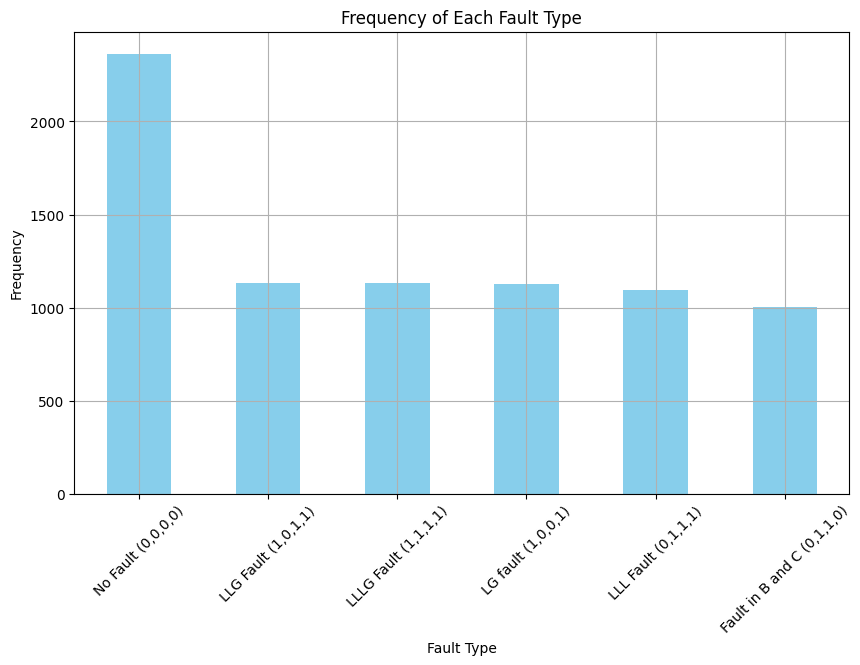

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

def classify_fault(row):
    G, C, B, A = row['G'], row['C'], row['B'], row['A']
    if (G, C, B, A) == (0, 0, 0, 0): 
        return 'No Fault (0,0,0,0)'
    elif (G, C, B, A) == (1, 0, 0, 1): 
        return 'LG fault (1,0,0,1)'
    elif (G, C, B, A) == (1, 0, 1, 1): 
        return 'LLG Fault (1,0,1,1)'
    elif (G, C, B, A) == (0, 1, 1, 1): 
        return 'LLL Fault (0,1,1,1)'
    elif (G, C, B, A) == (1, 1, 1, 1):
        return 'LLLG Fault (1,1,1,1)'
    elif (G,C,B,A) == (0,1,1,0):
        return 'Fault in B and C (0,1,1,0)'
    


# Apply this function to each row
df['Fault Type'] = df.apply(classify_fault, axis=1)
# Count the occurrences of each fault type
fault_counts = df['Fault Type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
fault_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Fault Type')
plt.xlabel('Fault Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

Como podemos ver hay una gran diferencia entre la distribucion de líneas de transmisión que no tuvieron falla, que las que si tuvieron en sus diversas fases. Siendo así, una diferencia del mas del doble entre ellas. Notemos de igual manera que las que si tuvieron error en alguna de sus fases estan bien balanceadas, variando en aproximadamente ~100 cada una.

Así mismo, existe una configuración la cual no etsa siendo considerada en el dataset pero que nosotros la ponemos, y es la de (0,1,1,0), la cual indica que hubo una falla en la fase B y C. 

Estos dos problemas son el inicio de nuestra limpieza de datos, ya que nos indica primeramente que hay que realizar una estratificación entre la clase que no hubo falla y las que si, y que la configuración (0,1,1,0) según el dataset no es válida, por lo que hay que escoger si investigar más del tema y el porqué no es válida o si solo no fue considerada, o bien omitir todos los ejemplares con esta configuración.

## Identificación de datos faltantes

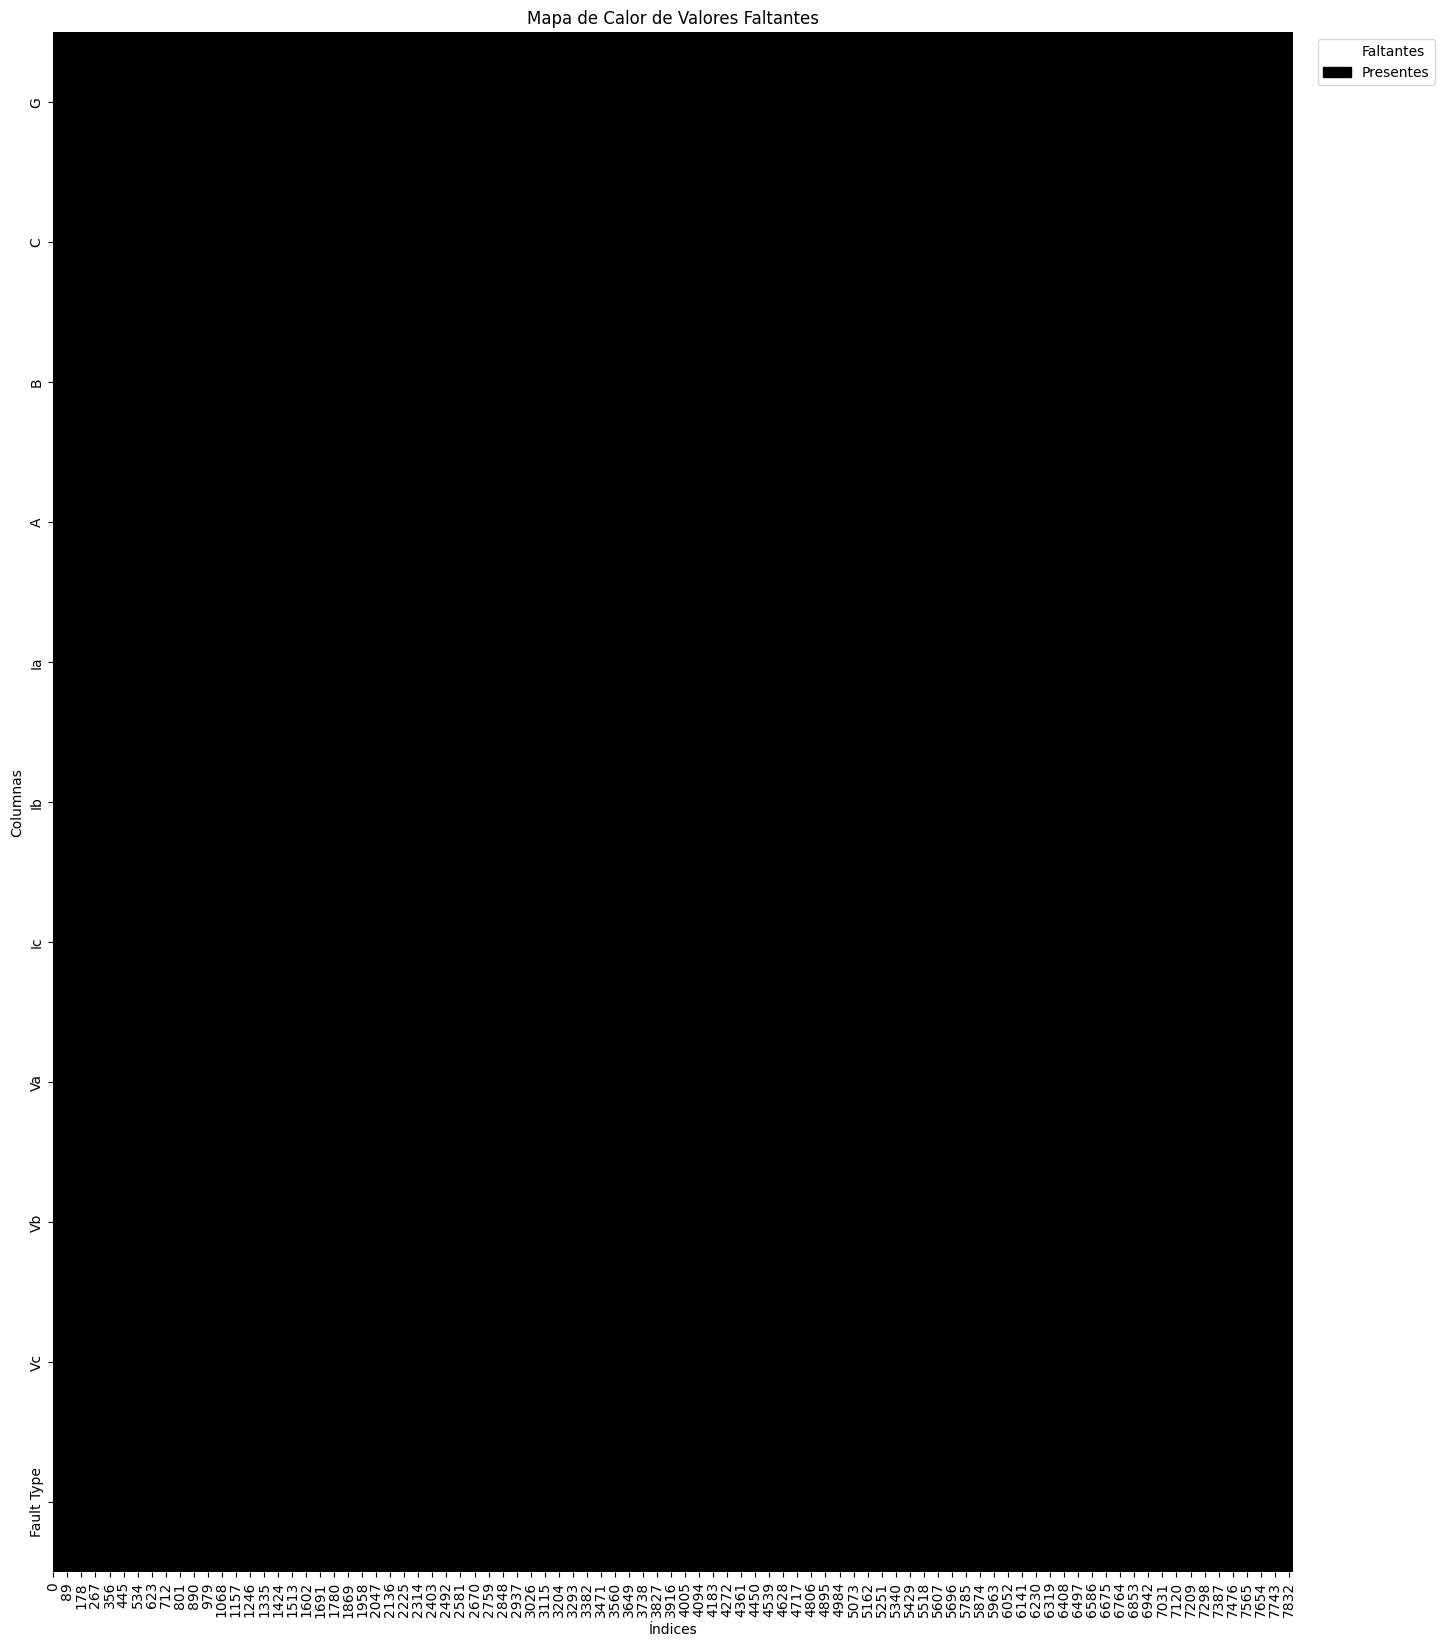

In [97]:
import matplotlib.patches as mpatches

# Mapa de calor invertido con todas las columnas y leyenda
plt.figure(figsize=(16, 20))
sns.heatmap(df.isnull().transpose(), cbar=False, cmap="binary_r", yticklabels=True)
plt.title("Mapa de Calor de Valores Faltantes")
plt.xlabel("Índices")
plt.ylabel("Columnas")

# Añadir leyenda
legend_labels = [
    mpatches.Patch(color="white", label="Faltantes"),
    mpatches.Patch(color="black", label="Presentes"),
]
plt.legend(handles=legend_labels, loc="upper right", bbox_to_anchor=(1.12, 1))
plt.show()

Considerando la información de arriba, podemos notar que no existen los valores nulos.
No obstante, este enfoque visual sirve principalmente como una inspección general. Para un análisis más detallado de los datos faltantes, es recomendable emplear otras herramientas específicas.

In [98]:
# Cantidad de valores faltantes por columna
missing_values = df.isnull().sum()
# Imprimir cantidad de valores faltantes
print(missing_values)

G             0
C             0
B             0
A             0
Ia            0
Ib            0
Ic            0
Va            0
Vb            0
Vc            0
Fault Type    0
dtype: int64


# Rango de columnas



In [99]:
# Obtener columnas numéricas
numeric_cols = df.select_dtypes(include=["number"]).columns

# Calcular y mostrar rangos
ranges = df[numeric_cols].agg(["min", "max"])
ranges

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
min,0,0,0,0,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
max,1,1,1,1,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


Notando que nuestro conjunto de entrenamiento (y por ende de entrada) varía por cada columna uniformemente en aproximadamente 2 veces su valor. Y que existe tanto valores muy grandes como valores muy pequeños, por lo que ésto nos dice que debe de existir una normalización con la finalidad de facilitar el entrenamiento y no haya problemas de desvanecimiento en el descenso por el gradiente.

# Matriz de Correlación

In [100]:
# Obtener columnas categóricas, para saber cuales quitar
categorical_cols = df.select_dtypes(include=["object"]).columns

# Quedarse con las columnas numéricas solamente, pero no asignar a df
# La variable numeric_cols la obtuvimos en un paso anterior.
df_numeric = df[numeric_cols]

# Imprimir la cantidad de columnas numéricas
print(f"Cantidad de columnas numéricas: {df_numeric.shape[1]}")

# Matriz de correlación usando pandas
correlation_matrix = df_numeric.corr()
# Mostrar matriz de correlación
correlation_matrix

Cantidad de columnas numéricas: 10


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
G,1.000000,-0.137611,0.196609,0.755273,0.041310,-0.031068,-0.003156,0.023808,-0.024048,0.002122
C,-0.137611,1.000000,0.747612,0.199335,0.000232,-0.109211,0.164323,0.018188,-0.068840,0.052998
B,0.196609,0.747612,1.000000,0.448807,0.014102,-0.139981,0.133321,0.037128,-0.075973,0.042473
A,0.755273,0.199335,0.448807,1.000000,0.036341,-0.074905,0.054071,0.029940,-0.053036,0.025873
Ia,0.041310,0.000232,0.014102,0.036341,1.000000,-0.374241,-0.276457,0.035682,-0.274612,0.246043
Ib,-0.031068,-0.109211,-0.139981,-0.074905,-0.374241,1.000000,-0.528291,0.029118,0.032101,-0.060023
Ic,-0.003156,0.164323,0.133321,0.054071,-0.276457,-0.528291,1.000000,-0.069137,-0.056967,0.122919
Va,0.023808,0.018188,0.037128,0.029940,0.035682,0.029118,-0.069137,1.000000,-0.480247,-0.450225
Vb,-0.024048,-0.068840,-0.075973,-0.053036,-0.274612,0.032101,-0.056967,-0.480247,1.000000,-0.566986
Vc,0.002122,0.052998,0.042473,0.025873,0.246043,-0.060023,0.122919,-0.450225,-0.566986,1.000000


Representada visualmente


<Axes: title={'center': 'Matriz de Correlación'}>

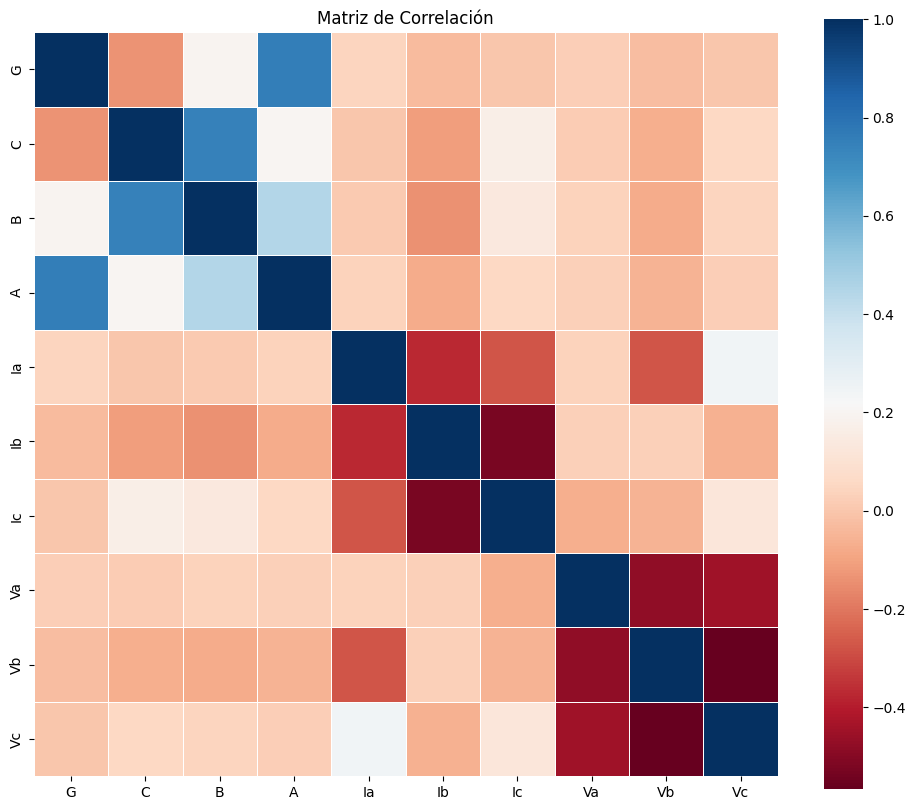

In [101]:
# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
plt.title("Matriz de Correlación")
# Add heatmap with grid
sns.heatmap(
    correlation_matrix,  # Matriz de correlación
    cmap="RdBu",  # Color con gradiente de rojo a azul
    annot=False,  # No mostrar valores en las celdas, se puede cambiar a True
    square=True,  # Hacer los cuadrados iguales
    linecolor="white",  # Color de las líneas que separan las celdas
    linewidths=0.5,  # Grosor de las líneas que separan las celdas
)

# Arquitectura de la Red Neuronal

Proponemos dos arquitecturas de perceptrón multicapa, una interpretando como un conjunto de escenarios la salida (es decir, en _one hot encoding_), y la otra como esta planteada el problema (con 4 posibles salidas y cada una con su valor binario de falla en la fase correspondiente).

Empezemos con la solución **sin one hot encoding**:

Proponemos para la solución del problema, un perceptrón multicapa con 3 capas, una de entrada con 6 neuronas, una escondida con 38 neuronas y una de salida con 4 neuronas.

De las cuales:

- 6 de entrada representan los voltajes e intensidades correspondientes $(Ia,Ib,Ic,Va,Vb,Vc)$.
- 38 en la capa escondida por que al basarnos del artículo <https://springerplus.springeropen.com/articles/10.1186/s40064-015-1080-x#:~:text=section%20is%20conclusion.-,Artificial%20neural%20network,form%20can%20be%20dealt%20with.>
- 4 neuronas de salida, cada una representando el valor binario de la falla en la fase correspondiente.



In [109]:
output_wo_oh =  df.iloc[:, :4]
input_wo_oh =  df.iloc[:,4:-1]



print(output_wo_oh.shape)
print(input_wo_oh.shape)


(7861, 4)
(7861, 6)


In [110]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

#Definimos el dispositivo que se usará.
device = torch.device('cpu')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder

In [111]:
class Electrical_nn (nn.Module):
     def __init__(self,input_size,hidden,output_size):
        '''
        Constructor con las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación logistica.
        '''
        super(Electrical_nn,self).__init__()
        self.input_layer = nn.Linear(input_size, hidden)
        self.output_layer = nn.Linear(hidden, output_size)
        self.activation = nn.Sigmoid()
        self.hist = []
        
     def forward(self,x):
        '''
        Propagacion hacia adelante
        '''
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
      #   x = self.activation(x)
        return x
     
     def train(self, X, Y, optimizer, steps, loss_func):
        '''
        Función de entrenamiento ya cuenta con el backpropagate. Se usa loss_func como parámetro para probar con las distintas funciones
        de pérdida
        '''     
        for step in range(steps):
            optimizer.zero_grad()
            output = self.forward(X)
            loss = loss_func(output, Y)
            loss.backward()
            optimizer.step()
            
            self.hist.append(loss.item())

        print(f'After {step} iterations, the error was {self.hist[-1]}')            
        plt.plot(self.hist)
        plt.title("Progreso error")
        plt.xlabel("ciclo")
        plt.ylabel("error")
        plt.show()
      

## Normalizacion de la entrada con MinMaxScaler

In [112]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(input_wo_oh)

print(x_normalized.shape)



(7861, 6)


In [113]:
xtrain,xtest,ytrain,ytest = train_test_split(x_normalized,output_wo_oh,train_size=0.8,stratify=output_wo_oh)

xtrain = torch.tensor(xtrain,dtype=torch.float32)
xtest = torch.tensor(xtest,dtype=torch.float32)
ytrain = torch.tensor(ytrain.values,dtype=torch.float32)
ytest = torch.tensor(ytest.values,dtype=torch.float32)


print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288, 4])
torch.Size([1573, 4])


## Entrenamiento

After 1999 iterations, the error was 2.329124927520752


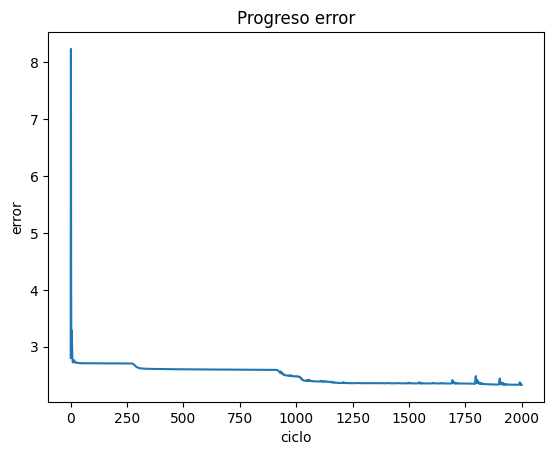

In [114]:
model1 = Electrical_nn(6,38,4)

opt = optim.Adam(model1.parameters(),lr=0.2)
loss_func = nn.CrossEntropyLoss()
model1.train(xtrain,ytrain,opt,2000,loss_func)



## Validación
Matriz de confusión:

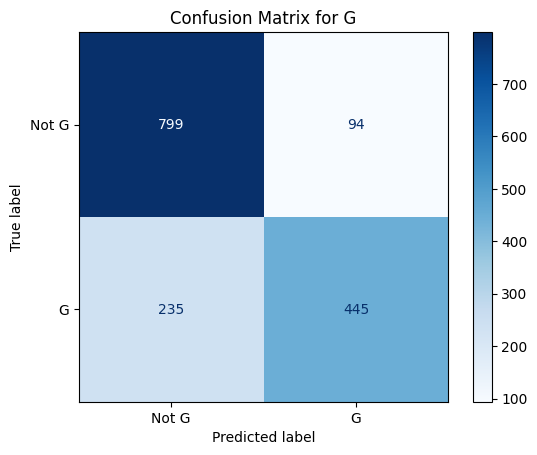

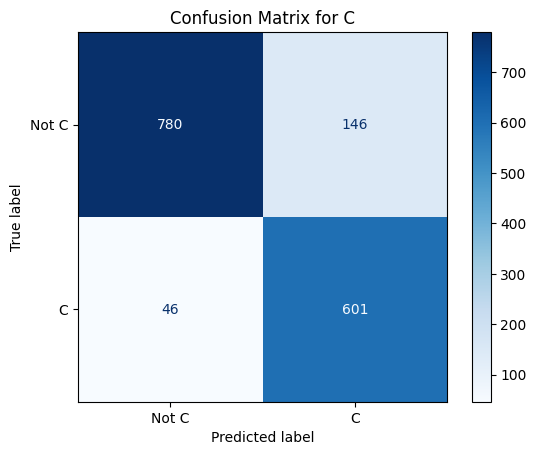

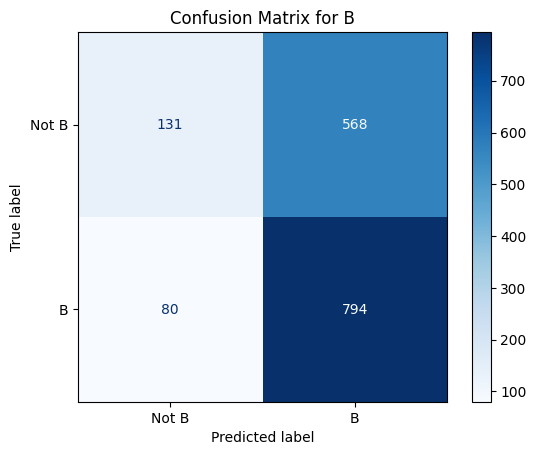

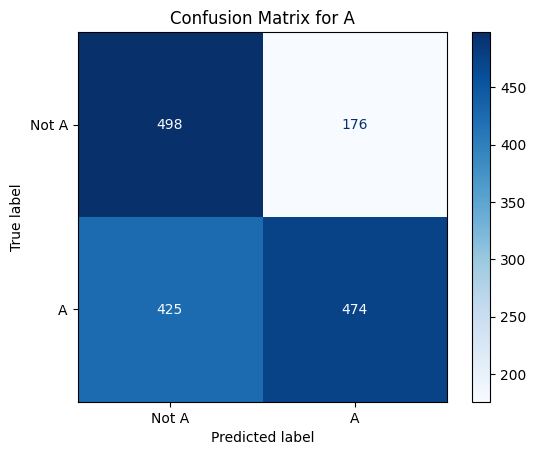

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay



# Make predictions on the test set
with torch.no_grad():
    predictions = model1(xtest)
    predictions = torch.sigmoid(predictions)  # Apply sigmoid to get probabilities
    predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary labels

# Convert the predictions and true labels to a suitable format for computing the confusion matrix
predicted_labels = predicted_labels.numpy()
true_labels = ytest.numpy()

# Compute the confusion matrix for each class
for i, class_name in enumerate(['G', 'C', 'B', 'A']):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {class_name}', class_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()



## Con One Hot encoding 

Codificación de las clases del 0 al 6.

In [116]:
def tranform_output(row):
    G, C, B, A = row['G'], row['C'], row['B'], row['A']
    if (G, C, B, A) == (0, 0, 0, 0): 
        return 0
    elif (G, C, B, A) == (1, 0, 0, 1): 
        return 1
    elif (G, C, B, A) == (1, 0, 1, 1): 
        return 2
    elif (G, C, B, A) == (0, 1, 1, 1): 
        return 3
    elif (G, C, B, A) == (1, 1, 1, 1):
        return 4
    elif (G,C,B,A) == (0,1,1,0):
        return 5
    


output_w_oh = df.apply(tranform_output, axis=1)
input_w_oh =  df.iloc[:,4:-1]



print(output_w_oh.shape)
print(input_w_oh.shape)




(7861,)
(7861, 6)


## Normalización de entrada con MinMaxScaler

In [117]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(input_w_oh)

print(x_normalized.shape)
x_normalized

(7861, 6)


array([[0.413869  , 0.49757125, 0.54305757, 0.83998528, 0.38440376,
        0.28435789],
       [0.30936644, 0.46036953, 0.50525074, 0.76760749, 0.39193015,
        0.34925764],
       [0.21514432, 0.4054293 , 0.44963504, 0.72895617, 0.3994813 ,
        0.38031664],
       ...,
       [0.46238877, 0.5233474 , 0.50960887, 0.60345407, 0.04029893,
        0.87214445],
       [0.4626245 , 0.52279168, 0.50993285, 0.61109955, 0.03796598,
        0.86685598],
       [0.46286823, 0.52223521, 0.51024963, 0.61871774, 0.0357486 ,
        0.86147711]])

In [118]:
xtrain,xtest,ytrain,ytest = train_test_split(x_normalized,output_w_oh, train_size=0.8,random_state=42,stratify=output_w_oh)

xtrain = torch.tensor(xtrain,dtype=torch.float32)
xtest = torch.tensor(xtest, dtype=torch.float32)
ytrain = torch.tensor(ytrain.values, dtype=torch.float32)
ytest = torch.tensor(ytest.values,dtype=torch.float32)



print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288])
torch.Size([1573])


Implementar One hot Encoding en el conjunto de entrenamiento y prueba.

In [119]:

ytrain = ytrain.long()

ytrain_oh = torch.zeros((ytrain.size(0),6))


for i in range(ytrain_oh.size(0)):
    ytrain_oh[i,ytrain[i]] = 1

ytest = ytest.long()
ytest_oh = torch.zeros((ytest.size(0),6))

for i in range(ytest.size(0)):
    ytest_oh[i,ytest[i]] = 1


print(xtrain.shape)
print(xtest.shape)
print(ytrain_oh.shape)
print(ytest_oh.shape)


torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288, 6])
torch.Size([1573, 6])


## Entrenamiento

After 1999 iterations, the error was 0.24171437323093414


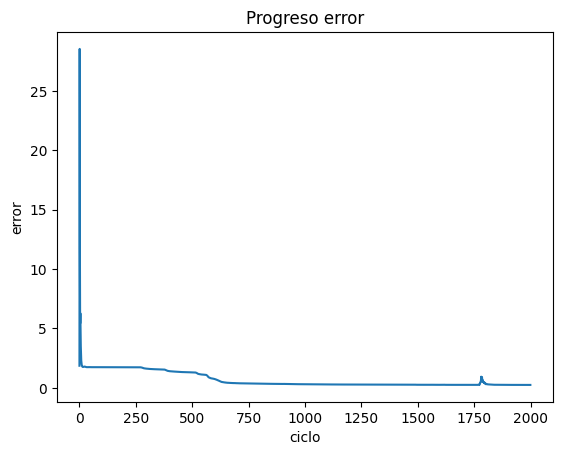

In [120]:
model2 = Electrical_nn(6,256,6)

opt = optim.Adam(model2.parameters(),lr=0.2)
loss_func = nn.CrossEntropyLoss()
model2.train(xtrain,ytrain_oh,opt,2000,loss_func)

# Validación

Matriz de confusión:

In [121]:
def plot_confusion_matrix(labels, preds, classes, type_of_set):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix on {typeSet}".format(typeSet = type_of_set))
    plt.show()

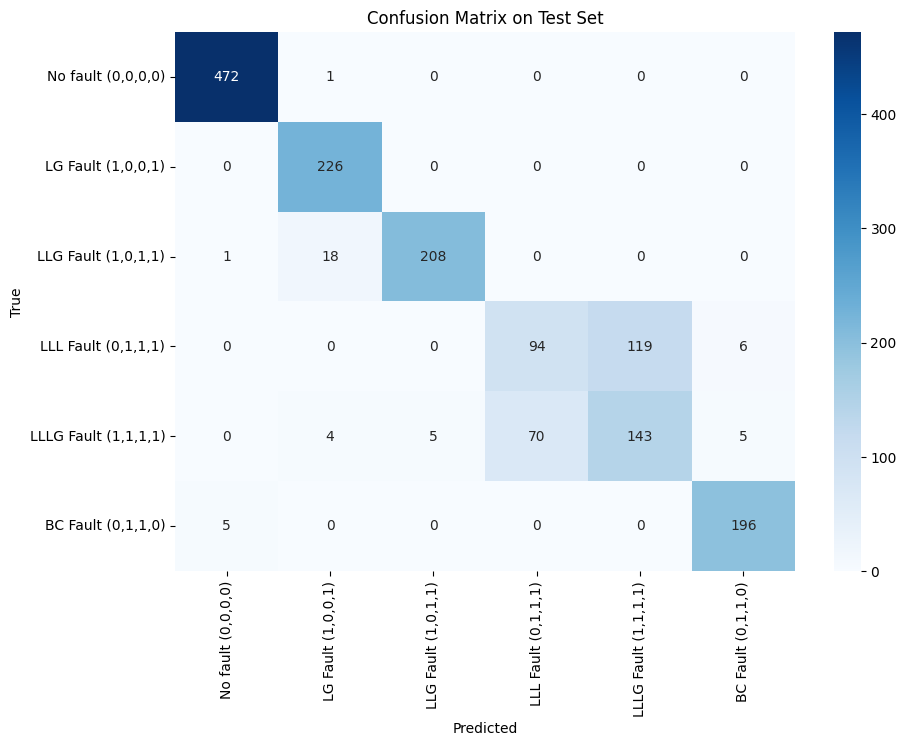

In [122]:

with torch.no_grad():
  y2_pred = model2(xtest).argmax(dim=1)
classes2 = ["No fault (0,0,0,0)", "LG Fault (1,0,0,1)", "LLG Fault (1,0,1,1)", "LLL Fault (0,1,1,1)", "LLLG Fault (1,1,1,1)", "BC Fault (0,1,1,0)"]



plot_confusion_matrix(ytest, y2_pred, classes2, 'Test Set')

    



Como podemos observar, la red entrenada con implementación de one hot encoding fue mucho más eficiente tanto en error como en validación con la matriz de confusión. 

# Algoritmo Genetico

In [23]:
class Gen_net(nn.Module):
    '''
    Definimos un modelo de red neuronal sobre el cual podamos 
    evaluar el algoritmo genético.
    '''
    def __init__(self, in_features, hidden_1, hidden_2, out_features):

        super(Gen_net,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
  
        self.capa_entrada = nn.Linear(in_features, hidden_1)
        self.capa_escondida = nn.Linear(hidden_1, hidden_2)
        self.capa_salida = nn.Linear(hidden_2, out_features)
        self.activacion = nn.Sigmoid()
        
    def forward(self, X):
            '''
            Define la función de feed forward, a partir de los datos
            de X. Usa una sigmoide entre las capas.
            '''
            X = X.to(self.capa_entrada.weight.dtype)
            X = self.capa_entrada(X)
            X = self.activacion(X)
            X = self.capa_escondida(X)
            X = self.activacion(X)
            X = self.capa_salida(X)
            X = self.activacion(X)
            return(X)

    def build_from_chromosome(self, chromosome):
        '''
        Define una función para que a partir de un cromosoma modifiques los 
        pesos de la red.        
        '''
        '''
        cromosoma = [
    [
        torch.tensor([[], []]),  Pesos de la capa de entrada
    ],
    [
        torch.tensor([[], []]),   Pesos de la capa oculta
    ],
    [
        torch.tensor([[], []]),   Pesos de la capa salida
    ]
    ]
        '''
        self.capa_entrada.weight.data = torch.tensor(chromosome[0][0])
        self.capa_escondida.weight.data = torch.tensor(chromosome[0][1])
        self.capa_salida.weight.data = torch.tensor(chromosome[0][2])
        
    def trainin(self, caracteristicas, calidad, optimizer):
        '''
        Define una función de entrenamiento como en la práctica anterior, pero utilizando la misma 
        función de error que se usa para obtener el fitness.
        '''
        criterion = nn.MSELoss() 
        error_history = []
        
        optimizer.zero_grad()
        outputs = self.forward(caracteristicas)
        optimizer.step()
        loss = criterion(calidad, caracteristicas)
        loss.backward()
        error = self.error(outputs, calidad)
                

In [24]:

class Gen_train():
    '''
    Define la estructura del algortimo genético
    '''
    def __init__(self, model, parent_scalar, operator_probabilities, population_size):
        '''
        Usa el parametro model para tener un ejemplar de la red sobre la cual puedas
        realizar las operaciones necesarias.
        Incializa la población utilizando una distribución t
        model es la red
        parent_scalar es la probabilidad de que la red sea elegida
        operator_probabilities es la probabilidad de que la red escoja crossover o mutacion
        population_size es el numero pesos(cromosomas) de la misma red
        population cromosomas
        '''
        self.model = model
        self.parent_scalar = parent_scalar
        self.operator_probabilities = operator_probabilities
        self.population_size = population_size
        self.population = []
        self.t_distribution = torch.distributions.StudentT(df = population_size-1)
        self.error_history = []
        
    def create_first_population(self):
        ''' '''
        in_features = self.model.in_features
        hidden_1 = self.model.hidden_1
        hidden_2 = self.model.hidden_2
        out_features = self.model.out_features
        for i in range(self.population_size):
            cromosoma = [[torch.randn(hidden_1, in_features), torch.randn(hidden_2, hidden_1), torch.randn(out_features, hidden_2)]]
            self.population.append(cromosoma)
        return self.population
    
    def get_weights(self, element):
        '''
        Función para obtener las matrices de pesos a partir de un elemento de la población.
        Debe tener las mismas dimensiones que los pesos para la red.
        '''
        
        if element < 0 or element >= len(self.population):
            raise ValueError("El índice del elemento está fuera de los límites de la población")
        cromosoma = self.population[element]
        return cromosoma[0]  # Devuelve las matrices de pesos del elemento
    
    def seleccion_de_cromosomas(self,error):
        numeros = [tensor.item() for tensor in error]
        pesos = [1 / num for num in numeros]
        total = sum(pesos)
        probabilidades = [peso / total for peso in pesos]
        seleccionados = random.choices(numeros, probabilidades, k=2)
        indice_seleccionado1 = numeros.index(seleccionados[0])
        indice_seleccionado2 = numeros.index(seleccionados[1])
        self.parent_scalar = indice_seleccionado1 if seleccionados[0] <= seleccionados[1] else indice_seleccionado2
        return indice_seleccionado1, indice_seleccionado2
    
    
    def set_chromosome(self, w1, w2, w3, element):
        '''
        Función para actualizar un elemento de la población a partir de los pesos que determinan 
        a una red. Se actualizará el ejemplar de la población que se encuentre en la posición
        element.
        '''
        if element < 0 or element >= len(self.population):
            raise ValueError("El índice del elemento está fuera de los límites de la población")
        # Actualiza los pesos del elemento en la población
        self.population[element] = [[w1, w2, w3]]
    
    def fitness(self, caracteristicas, calidad, element):
        '''
        Función para determinar la adecuación de un elemento de la población. 
        En esté caso, la adecuación nos servirá para determinar los elementos
        más aptos. Para está implementación se considerará que una adecuación 
        menor será de un menor individuo, por lo que tendrá mayores 
        probabilidades de reproducirse.  
        error de el feedfoward  
        elemento de     
        '''    
        self.model.build_from_chromosome(self.population[element])
 
        # Llamar a la función forward con el tensor convertido
        prediccion_con_pesos = self.model.forward(caracteristicas)

        error_calculado = nn.MSELoss()
        error = error_calculado(prediccion_con_pesos, calidad)
        error = error.to(torch.float32)
        return error.detach()
    
    def generar_lista_error(self,caracteristicas,calidad):
        lista_error = []

        for i in range(self.population_size):
            error_temp = self.fitness(caracteristicas,calidad,i)#fitness ya manda llamar population!!
            error_temp = error_temp.to(torch.float32)
            lista_error.append(error_temp)
        return lista_error
    
    def mezclar_matrices(self, indx_cromosoma1, indx_cromosoma2):
        matriz_final = []
        matriz1 = self.get_weights(indx_cromosoma1)[i]
        matriz2 = self.get_weights(indx_cromosoma2)[i]
        
        # Generar una máscara aleatoria para decidir de cuál matriz tomar cada elemento
        mascara = np.random.randint(0, 2, size=matriz1.shape)
        
        # Usar la máscara para seleccionar los elementos de las dos matrices
        matriz_mezclada = torch.where(torch.tensor(mascara, dtype=torch.bool), matriz1, matriz2)
        
        matriz_final.append(matriz_mezclada)
        return matriz_final
    
    def cambia_cromosoma_mas_debil(self, nuevo_cromosoma):
        self.set_chromosome(nuevo_cromosoma[0],nuevo_cromosoma[1],nuevo_cromosoma[2],self.parent_scalar)
    

    def crea_nodo_mutado(self, error):
        indice1, indice2 = self.seleccion_de_cromosomas(error)
        cromo1 = self.get_weights(indice1)
        
        capa_e1=cromo1[0] #  pesos de la capa de entrada
        capa_o1=cromo1[1] #  pesos de la capa oculta
        capa_s1=cromo1[2] #  pesos de la capa de salida
        
        
         # Mutación en la capa de entrada
        indice_peso_e1 = torch.randint(0, capa_e1.shape[0], (1,)).item() # Índice aleatorio para un peso en la capa de entrada
        modificacion_e1 = self.t_distribution.sample().item()  # Generar una modificación aleatoria
        capa_e1[indice_peso_e1] += modificacion_e1  # Aplicar la mutación

        # Mutación en la capa oculta
        indice_peso_o1 = torch.randint(0, capa_o1.shape[0], (1,)).item() # Índice aleatorio para un peso en la capa oculta
        modificacion_o1 = self.t_distribution.sample().item()  # Generar una modificación aleatoria
        capa_o1[indice_peso_o1] += modificacion_o1  # Aplicar la mutación

        # Mutación en la capa de salida
        indice_peso_s1 = torch.randint(0, capa_s1.shape[0], (1,)).item()# Índice aleatorio para un peso en la capa de salida
        modificacion_s1 = self.t_distribution.sample().item()  # Generar una modificación aleatoria
        capa_s1[indice_peso_s1] += modificacion_s1  # Aplicar la mutación

        # Devolver los cromosomas mutados
        return [capa_e1,capa_o1,capa_s1]
    
    def cross_over(self,error):
        for i in range(15):
            m1,m2=self.seleccion_de_cromosomas(error)
            resultado = self.mezclar_matrices(m1,m2)
            self.cambia_cromosoma_mas_debil(resultado) 
            
    def mutate_nodes(self,error):
        nodo_mutado = self.crea_nodo_mutado(error)
        self.cambia_cromosoma_mas_debil(nodo_mutado)
        
    def train(self, caracteristicas, calidad, steps):
        '''
        Define la función de entrenamiento, la cuál se realizará el número de pasos 
        seleccionados. Usa la variable de parent_scalar para determinar la probabilidad 
        de que un individuo de la población sea remplazado en cada iteración. Muestra 
        una gráfica del error al finalizar el entrenamiento. Y regresa una red con
        los pesos del individuo con mejor fitness al finalizar el entrenamiento.
        '''
        error_history=[]
        self.create_first_population()
        for i in range(steps):
         error = []
         error = self.generar_lista_error(caracteristicas,calidad)
         error = torch.tensor(error, dtype=torch.float32)
         self.cross_over(error)
         self.mutate_nodes(error)
         numeros = []
         for tensor in error:
            numero = tensor.item()  # Assign tensor.item() to a single variable, not a list
            numeros.append(numero)  # Append numero to the numeros list
         promedio = sum(numeros) / len(numeros)
         error_history.append(promedio)
         
    
        print(error_history)
        plt.plot(error_history)
        plt.xlabel('Generation')
        plt.ylabel('Error')
        plt.title('Error Over Generations')
        plt.show()
   

In [25]:

print(xtrain.shape)
print(xtest.shape)
print(ytrain_oh.shape)
print(ytest_oh.shape)

torch.Size([6288, 6])
torch.Size([1573, 6])
torch.Size([6288, 7])
torch.Size([1573, 7])


In [26]:
gen_net = Gen_net(6,7, 10, 7)
gen_train = Gen_train(gen_net, 0.92, 0.5, 50)
gen_train.train(xtrain, ytrain_oh,1000)

C:\Users\rosas\AppData\Local\Temp\ipykernel_14944\1630100958.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.capa_entrada.weight.data = torch.tensor(chromosome[0][0])
C:\Users\rosas\AppData\Local\Temp\ipykernel_14944\1630100958.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.capa_escondida.weight.data = torch.tensor(chromosome[0][1])
C:\Users\rosas\AppData\Local\Temp\ipykernel_14944\1630100958.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.capa_salida.weight.data = torch.tensor(chromosome[0][2])


IndexError: list index out of range